# Sentiment Analysis of tweets

In [1]:
# pip install tweepy
import tweepy
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
from textblob.sentiments import NaiveBayesAnalyzer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
from string import punctuation
from nltk.corpus import stopwords
import re
import nltk
import numpy as np
import pandas as pd

In [2]:
#nltk.download('vader_lexicon')

In [4]:
#Running the python script containing API keys
%run C:\\Users\\korupos\\Documents\\Sentiment\\key.ipynb

In [6]:
auth = tweepy.OAuthHandler(consumer_api_key, consumer_api_secret_key)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth)
api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

# The last command prints a message and waits if the rate limit is exceeded
# Twitter allows 15 requests per application per 15 minutes

## this chunk takes too long to scrape

In [ ]:
# df = pd.DataFrame(columns=['screen_name', 'name', 'date_time', 'location', 'text'])
# x = "desantis"

# for tweet in tweepy.Cursor(api.search, q= x, count=1000, result_type="recent",
#                            include_entities=True, lang="en").items():
#     df = df.append(pd.Series([tweet.user.screen_name, tweet.user.name, tweet.created_at, tweet.user.location, tweet.text], index=df.columns), ignore_index=True)

# df.shape #query results stored in 'df' dataframe

## This scrapes quickly but have to check max tweets that could be scraped

In [56]:
df = pd.DataFrame(columns=['screen_name', 'name', 'date_time', 'location', 'text'])
x = "desantis"
for tweet in tweepy.Cursor(api.search, q=x, lang='en').items(1000):
    df = df.append(pd.Series([tweet.user.screen_name, tweet.user.name, tweet.created_at, tweet.user.location, tweet.text], index=df.columns), ignore_index=True)
df.shape

(1000, 5)

In [57]:
df[['text', 'name', 'date_time']]

,text,name,date_time
0,RT @seanhannity: FLORIDA SAYS ‘THANKS’: Govern...,Ruben,2021-05-05 18:14:30
1,RT @seanhannity: FLORIDA SAYS ‘THANKS’: Govern...,#MAGA,2021-05-05 18:14:30
2,RT @thebradfordfile: Ron DeSantis is single-ha...,Va,2021-05-05 18:14:27
3,RT @BioWhiteFemale: @SwainForSenate @GovRonDeS...,Klee,2021-05-05 18:14:26
4,RT @POLICEINFLA: POLICE/FLORIDA NEWS: @GovRon...,TheLadyEagle,2021-05-05 18:14:22
...,...,...,...
995,RT @seanhannity: FLORIDA SAYS ‘THANKS’: Govern...,Laurie Anne,2021-05-05 17:39:06
996,RT @Grahmptr: BREAKING : Governor Ron DeSantis...,proud deplorable Jenn,2021-05-05 17:39:06
997,RT @thebradfordfile: Ron DeSantis is single-ha...,michelle kathryn,2021-05-05 17:39:05
998,"RT: ""Some want to defund the police. We're fun...",Phil Ammann 🙄⌨️🙄,2021-05-05 17:39:03


## Model 1 : GCP NLP API

In [13]:
import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]= "C:\\Users\\korupos\\Documents\\Sentiment\\senti-311518-1b03476e63cd.json"

In [14]:
# Imports the Google Cloud client library
from google.cloud import language_v1

In [15]:
# Instantiates a client
client = language_v1.LanguageServiceClient()

In [58]:
senti = []
for i in df['text']:
    text = i
    document = language_v1.Document(content=text, type_=language_v1.Document.Type.PLAIN_TEXT)
    sentiment = client.analyze_sentiment(request={'document': document}).document_sentiment
    senti.append(round(sentiment.score, 2))

In [59]:
df['sentiment_score'] = senti

## Saved to csv

In [60]:
df.to_csv('1000_tweets.csv')

In [61]:
pos = df[df.sentiment_score > 0]
neg = df[df.sentiment_score < 0]
neu = df[df.sentiment_score == 0]

## Results

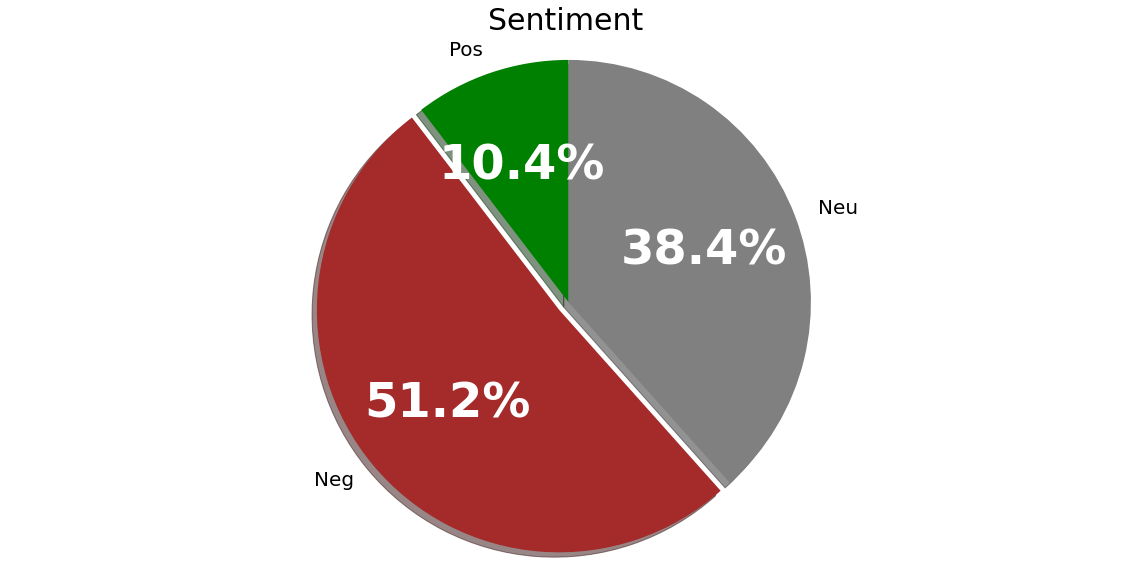

In [65]:
import matplotlib.pyplot as plt

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = 'Pos', 'Neg', 'Neu'
sizes = [len(pos), len(neg), len(neu)]
colors = 'green','brown','grey'

explode = (0, 0.05, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots(figsize=(20,10))
_, _, autopcts = ax1.pie(sizes, explode=explode, labels=labels, colors = colors, autopct='%1.1f%%', shadow=True, startangle=90,
       textprops={'fontsize': 20})
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.setp(autopcts, **{'color':'white', 'weight':'bold', 'fontsize':48})
ax1.set_title('Sentiment', fontdict={'fontsize': 30})

plt.show()

In [66]:
pos.sort_values(by=['sentiment_score'], inplace=True, ascending = False)
neg.sort_values(by=['sentiment_score'], inplace=True)

<ipython-input-66-17f8801a99d5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pos.sort_values(by=['sentiment_score'], inplace=True, ascending = False)
<ipython-input-66-17f8801a99d5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  neg.sort_values(by=['sentiment_score'], inplace=True)


In [76]:
pos[['text', 'sentiment_score']].head(10)

,text,sentiment_score
109,@GregAbbott_TX Thank you Gov Abbott. I am Flor...,0.9
101,"Wow that's awesome news, thank you for everyth...",0.9
306,RON DESANTIS- KEEP UP THE GREAT WORK YOU ARE D...,0.9
927,@michterris @GovernorRon @realJEXITusa @siggyf...,0.8
65,RT @anthonyc3069: @ABC Desantis has done a gre...,0.7
231,"This is awesome, DeSantis fans!\n\nhttps://t.c...",0.6
334,We will never get to leave this house again. \...,0.5
99,@funder Desantis is the best Governor we’ve ha...,0.5
773,RT @EssenThe: @michterris @GovernorRon @realJE...,0.5
3,RT @BioWhiteFemale: @SwainForSenate @GovRonDeS...,0.5


In [77]:
neg[['text', 'sentiment_score']].head(10)

,text,sentiment_score
361,@Emperor_of_PA Yeah these people have somehow ...,-0.9
502,RT @OmariJHardy: I would call Desantis's posit...,-0.8
769,@nikkifried @GovRonDeSantis I highly doubt DeS...,-0.8
67,RT @OmariJHardy: I would call Desantis's posit...,-0.8
530,RT @OmariJHardy: Now DeSantis is describing pr...,-0.8
779,DeSantis is sending a dangerous signal to othe...,-0.8
624,RT @OmariJHardy: I would call Desantis's posit...,-0.8
648,DeSantis just gave $1000 bonuses to cops but H...,-0.8
619,@MaureenMannion2 @PalmerReport DeSantis's repu...,-0.8
393,@AK4WA They don’t understand how many who didn...,-0.8


## Tweet Distribution

Model 1 : GCP


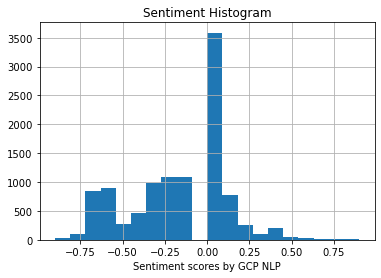

Total Tweets : 10824
Neutral Tweets : 3587
Positive Tweets : 1438
Negative Tweets : 5799


In [53]:
print('Model 1 : GCP')
df['sentiment_score'].hist(bins=20)
plt.title('Sentiment Histogram')
plt.xlabel('Sentiment scores by GCP NLP')
plt.show()
print('Total Tweets : ' + str(len(df)))
print('Neutral Tweets : ' + str((df['sentiment_score'] == 0).sum()))
print('Positive Tweets : ' + str((df['sentiment_score'] > 0).sum()))
print('Negative Tweets : ' + str((df['sentiment_score'] < 0).sum()))

# Ignore below

## Cleaning of tweet corpus

In [25]:
# blobs = []                #This list holds the cleaned tweets

# for i in range(len(df)):
#     tweet = df['text'][i]
#     tweet = tweet.strip(punctuation).lower()
#     tweet = re.sub(r'http\S+', ' ', tweet)
#     tweet = re.sub(r'@\S+', ' ', tweet)
#     tweet = re.sub(r'#', '', tweet)
#     tweet = re.sub(r'[^a-z]+', ' ', tweet)
#     tweet = re.sub(r'rt', ' ', tweet)
    
#     blobs.append(tweet)

## Model 2 : TextBlob

In [26]:
# polarity = []
# #subjectivity = []

# for i in range(len(blobs)):
#     xyz = TextBlob(blobs[i])
#     polarity.append(xyz.sentiment.polarity)
# #    subjectivity.append(xyz.sentiment.subjectivity)

In [27]:
# df['TextBlob_score'] = polarity
# #df['subjectivity'] = subjectivity

In [29]:
# df['TextBlob_score'].mean()

0.07414199775128084

## Model 3 : Vader

In [30]:
# analyzer = SentimentIntensityAnalyzer()
# sentiment = {}
# pol = [0]*len(df)
    
# for i in range(len(df)):
#     tweet = df['text'][i]
#     sentiment[i] = analyzer.polarity_scores(tweet)
#     pol[i] = sentiment[i]['compound']
# df['Vader_score'] = pol

## Results

Model 2 : TextBlob


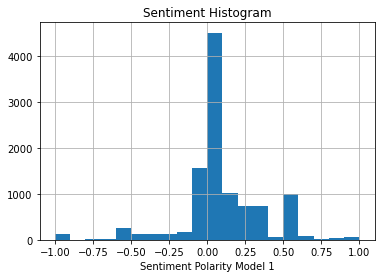

Total Tweets : 10824
Neutral Tweets : 4115
Positive Tweets : 4177
Negative Tweets : 2532


In [35]:
# print('Model 2 : TextBlob')
# df['TextBlob_score'].hist(bins=20)
# plt.title('Sentiment Histogram')
# plt.xlabel('Sentiment Polarity by TextBlob')
# plt.show()
# print('Total Tweets : ' + str(len(df)))
# print('Neutral Tweets : ' + str((df['TextBlob_score'] == 0).sum()))
# print('Positive Tweets : ' + str((df['TextBlob_score'] > 0).sum()))
# print('Negative Tweets : ' + str((df['TextBlob_score'] < 0).sum()))

Model 3 : Vader


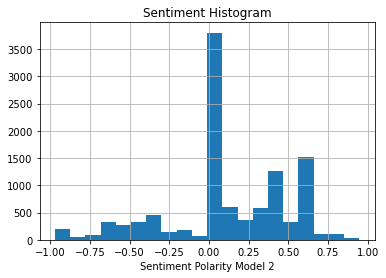

Total Tweets : 10824
Neutral Tweets : 3645
Positive Tweets : 5045
Negative Tweets : 2134


In [36]:
# print('Model 3 : Vader')
# df['Vader_score'].hist(bins=20)
# plt.title('Sentiment Histogram')
# plt.xlabel('Sentiment Polarity by Vader')
# plt.show()
# print('Total Tweets : ' + str(len(df)))
# print('Neutral Tweets : ' + str((df['Vader_score'] == 0).sum()))
# print('Positive Tweets : ' + str((df['Vader_score'] > 0).sum()))
# print('Negative Tweets : ' + str((df['Vader_score'] < 0).sum()))

Model 1 : GCP


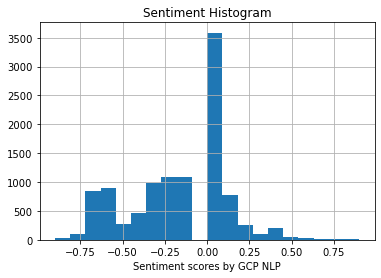

Total Tweets : 10824
Neutral Tweets : 3587
Positive Tweets : 1438
Negative Tweets : 5799


In [37]:
print('Model 1 : GCP')
df['sentiment_score'].hist(bins=20)
plt.title('Sentiment Histogram')
plt.xlabel('Sentiment scores by GCP NLP')
plt.show()
print('Total Tweets : ' + str(len(df)))
print('Neutral Tweets : ' + str((df['sentiment_score'] == 0).sum()))
print('Positive Tweets : ' + str((df['sentiment_score'] > 0).sum()))
print('Negative Tweets : ' + str((df['sentiment_score'] < 0).sum()))

In [34]:
# df.to_csv('analysis.csv',index=False,encoding='utf-8')

## Sample neutral

In [134]:
#sentiment = analyzer.polarity_scores('do you think florida should open eligibility for the covid vaccine to all adults')
#sentiment

{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}

## Sample negative

In [128]:
#sentiment = analyzer.polarity_scores('wtf i live in florida and still cannot get the vaccine')
#sentiment

{'neg': 0.297, 'neu': 0.703, 'pos': 0.0, 'compound': -0.5859}

## Sample positive

In [135]:
#sentiment = analyzer.polarity_scores('i am happy to say as a year old resident of florida i received my first moderna vaccine this morning ')
#sentiment

{'neg': 0.0, 'neu': 0.812, 'pos': 0.188, 'compound': 0.5719}